## Options Pricing

We estimate option prices using implied volatility

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [40]:
from datetime import datetime
import re

calls = pd.DataFrame()
puts = pd.DataFrame()

urls = [
        'https://finance.yahoo.com/quote/%5EGSPC/options?date=1579219200&p=%5EGSPC', 
        'https://finance.yahoo.com/quote/%5EGSPC/options?p=%5EGSPC&date=1584662400',
        'https://finance.yahoo.com/quote/%5EGSPC/options?date=1592524800&p=%5EGSPC',
        'https://finance.yahoo.com/quote/%5EGSPC/options?date=1608249600&p=%5EGSPC',
        'https://finance.yahoo.com/quote/%5EGSPC/options?date=1639699200&p=%5EGSPC'
       ]

for url in urls:
    timestamp = int(re.findall('\d{5,15}', url)[0])
    days_to_expiry = (datetime.fromtimestamp(timestamp) - datetime(2020,1,14,1,0)).days
    call_data, put_data = pd.read_html(url)
    call_data['Days to Expiry'] = pd.Series(call_data.shape[0]*[days_to_expiry])
    put_data['Days to Expiry'] = pd.Series(put_data.shape[0]*[days_to_expiry])
    calls, puts = pd.concat([calls, call_data]), pd.concat([puts, put_data])



In [41]:
#current price for S&P 500 (14.1.2020, 16:17)
calls['Current Stock Price'] = calls.shape[0]*[3283.27]
puts['Current Stock Price'] = puts.shape[0]*[3283.27]

calls['Mean Price'] = (calls['Bid'] + calls['Ask'])/2
puts['Mean Price'] = (puts['Bid'] + puts['Ask'])/2

cols = ['Mean Price', 'Bid', 'Ask', 'Strike', 'Current Stock Price', 'Days to Expiry']
calls, puts = calls[cols], puts[cols]
calls.index = np.arange(calls.shape[0])
puts.index = np.arange(puts.shape[0])



In [43]:
calls.to_csv(r'C:\\Users\steff\Documents\Jupyter\Option Pricing\calls.csv')
puts.to_csv(r'C:\\Users\steff\Documents\Jupyter\Option Pricing\puts.csv')

In [48]:
from scipy.stats import norm

def black_scholes_price(row, call=True):
    #Models price of a put option
    #K: strike price
    #F: forward
    #T: time to expiry
    #sigma: volatility, a model parameter
    S = row['Current Stock Price']
    T = row['Days to Expiry']
    K = row['Strike']
    sigma = row['Implied Volatility']
    d1 = (np.log(S / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))   
    d2 = (np.log(S / K) - 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))   
    return S*norm.cdf(d1)-K*norm.cdf(d2) if call else K*norm.cdf(-d2)-S*norm.cdf(-d1) 

def vega(row):
    #F: spot price
    #K: strike price
    #T: time to maturity
    #sigma: volatility of underlying asset 
    S = row['Current Stock Price']
    T = row['Days to Expiry']
    K = row['Strike']
    sigma = row['Implied Volatility']
    d1 = (np.log(S / K) + (0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))    
    vega = S * norm.pdf(d1) * np.sqrt(T)    
    return vega

def implied_volatility(S,T,K,P, iterations=1000, initial=1, learning_rate=0.01):
    #computes implied volatility at precision eps
    sigma = initial
    for _ in range(iterations):
        loss = (black_scholes_price(S, T, K, sigma)-P)**2
        sigma -= learning_rate/vega(S,T,K,sigma)
    return sigma
    

In [4]:
data = pd.read_html('https://finance.yahoo.com/quote/SPY/options?p=SPY')
calls, puts = data[0], data[1]

In [49]:
for df in [calls, puts]:
    df['Implied Volatility'] = pd.Series(1, index=range(df.shape[0]))
    tol = 0.001
    for _ in range(20):
        df['Black-Scholes Price']  = df.apply(black_scholes_price, axis=1)
        delta = df['Black-Scholes Price'] - df['Mean Price']
        loss = np.sum(delta ** 2) / df.shape[0]
        print(loss)
        if loss<tol:
            break
        df['Vega'] = df.apply(vega, axis=1)
        df['Implied Volatility'] -= delta / df['Vega'] 


5651909.452322776
8744042.090901708


C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]
C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


420895.47240733024


C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\steff\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


194609.8236607956
145862.32663809747
82731.09732133432
87720.97500563026
49579.204664326484
64709.45637846445
130835.27445756011
31423.82104694766
1443.3157515284752
5.875882445688644
1218.2787407907504
518.4566449917106
6.624877593060016
1.2068593239916046
3486.205906851777
1285.32808768155
11.363675714751176
9382350.078964857
4728196.066802293
296372.5487387291
181596.1239139573
262086.07304252504
91102.29210710863
193663.58629517764
66264.0665036727
147161.38615750163
266704.67009311164
702568.2355308201


C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in double_scalars
  del sys.path[0]
C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\steff\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars


259003.7892607347
40771.85474869805
0.03249849130564531
67.58078482424075
26393.16710812324
29311.83096870863
24732.64531280655
15635.742301212518
2468.874581645194


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X=df['Strike'].to_numpy().reshape(-1,1)

poly = PolynomialFeatures(4)
polynomial_features = poly.fit_transform(X)

y= df['Implied Volatility'].dropna()

reg = LinearRegression()
reg.fit(polynomial_features[df['Implied Volatility'].notna()], y)
ypred= reg.predict(polynomial_features)

df['Implied Volatility'] = ypred
df['Black-Scholes Price'] = df.apply(black_scholes_price, axis=1)

In [51]:
puts

,Mean Price,Bid,Ask,Strike,Current Stock Price,Days to Expiry,Implied Volatility,Black-Scholes Price,Vega
0,0.025,0.00,0.05,1000.0,3283.27,3,NaN,NaN,NaN
1,0.025,0.00,0.05,1100.0,3283.27,3,NaN,NaN,NaN
2,0.025,0.00,0.05,1200.0,3283.27,3,NaN,NaN,NaN
3,0.175,0.05,0.30,1250.0,3283.27,3,NaN,NaN,NaN
4,0.050,0.00,0.10,1300.0,3283.27,3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
365,137.050,132.20,141.90,2800.0,3283.27,703,NaN,NaN,NaN
366,159.300,158.10,160.50,2900.0,3283.27,703,NaN,NaN,NaN
367,185.450,184.10,186.80,3000.0,3283.27,703,NaN,NaN,NaN
368,327.900,326.00,329.80,3400.0,3283.27,703,NaN,NaN,NaN


In [1]:
plt.figure(figsize=(13,8)) 
sns.lineplot(data = df, x='strike_price', y='mean_put', label='Actual put price')
sns.scatterplot(data = df, x='strike_price', y='bs_price', label='Estimated put price', color='red', marker='x')
plt.xlabel('Strike price')
plt.ylabel('Put option price')


NameError: name 'plt' is not defined

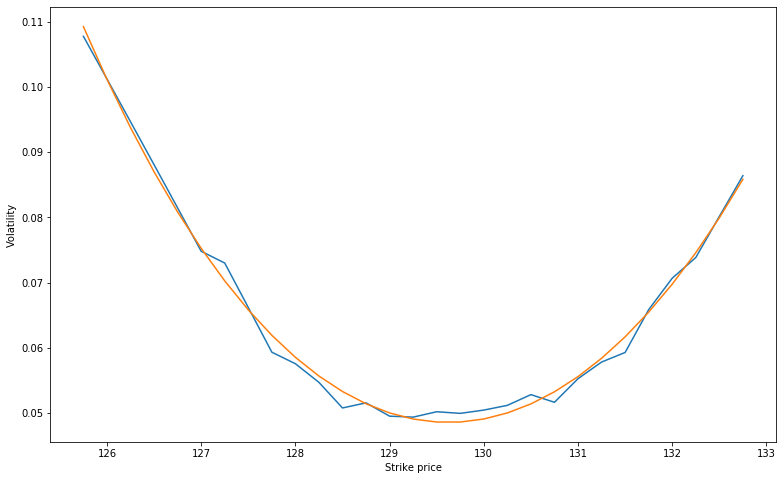

In [160]:
fig = plt.figure(figsize=(13,8)) 
ax = fig.add_subplot()
ax.set_xlabel('Strike price')
ax.set_ylabel('Volatility')
ax.plot(df['strike_price'][y.notna()], y)
ax.plot(df['strike_price'], ypred)